In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, fit_and_score_pipeline
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC


In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [7]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0

X, y = data[:,:-1], data[:, -1]

X, y, idx = balanced_sampling(X, y, r = 3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f'X.shape={X.shape}, y.shape={y.shape}')

a=0.10662111516202229, r=3, gamma=19.758010521281683
X.shape=(8362, 64), y.shape=(8362,)


# Naive fit

In [8]:

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.7477082502989238

# Hyperparameter tuning

In [21]:
# optimize kernal
param_range = range(1, 200, 20)

regularization_param = 1
kernal = 'rbf' #{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
degree = 3 # polynormal kernal degree, ignored by all other kernals, default=3
gamma = 'scale' # gamma{‘scale’, ‘auto’} or float, default=’scale’
coef0 = 0.0 # float, Independent term in kernel function. Only significant in ‘poly’ and ‘sigmoid’. default=0.0
# shrinkingbool, default=True
# probabilitybool, default=False
# tolfloat, default=1e-3 Tolerance for stopping criterion.
max_iter = -1 #int, default=-1
random_state = 0 #int default= None

train_results = []
test_results = []
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    classifier = SVC(C=regularization_param,
                     kernel=k,
                     gamma=gamma,
                     random_state=random_state
                    )
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    train_score_f1, test_score_f1, _ = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='f1')
    train_score_r, test_score_r, _ = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='recall')
    train_score_p, test_score_p, _ = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='precision')
    train_score_a, test_score_a, _ = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='accuracy')
    train_results.append((k, train_score_f1, train_score_r, train_score_p, train_score_a))
    test_results.append((k, test_score_f1, test_score_r, test_score_p, test_score_a))


(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)


[['linear' '0.05263157894736842' '0.027210884353741496' '0.8'
  '0.7542662116040956']
 ['poly' '0.03846153846153846' '0.02040816326530612' '0.3333333333333333'
  '0.7440273037542662']
 ['rbf' '0.026845637583892617' '0.013605442176870748' '1.0'
  '0.7525597269624573']
 ['sigmoid' '0.22222222222222224' '0.14285714285714285' '0.5'
  '0.7491467576791809']]
[0.05263158 0.02721088 0.8        0.75426621]
[0.03846154 0.02040816 0.33333333 0.7440273 ]
[0.02684564 0.01360544 1.         0.75255973]
[0.22222222 0.14285714 0.5        0.74914676]


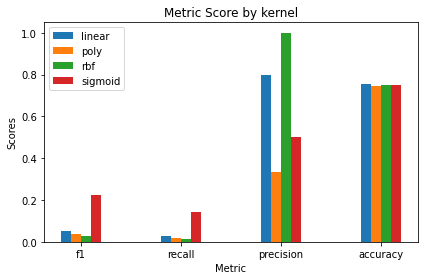

In [41]:
test_results_array = np.array(test_results)
train_results_array = np.array(train_results)
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


print(test_results_array)
labels = ['f1', 'recall', 'precision', 'accuracy']
test_linear = test_results_array[0, 1:].astype(float)
test_poly = test_results_array[1, 1:].astype(float)
test_rbf = test_results_array[2, 1:].astype(float)
test_sigmoid = test_results_array[3, 1:].astype(float)


print(test_linear)
print(test_poly)
print(test_rbf)
print(test_sigmoid)
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/4*6, test_linear, width, label='linear')
rects2 = ax.bar(x - width/4*2, test_poly, width, label='poly')
rects3 = ax.bar(x + width/4*2, test_rbf, width, label='rbf')
rects4 = ax.bar(x + width/4*6, test_sigmoid, width, label='sigmoid')


# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xlabel('Metric')
ax.set_title('Metric Score by kernel')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
# ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()
